In [1]:
!pip install kaggle
!pip install wordcloud

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"praneethratna","key":"1ffc3d4eb8d9e2d8b123587bece7ff97"}'}

In [3]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Attention, Dense, BatchNormalization, Dropout, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from wordcloud import WordCloud

In [5]:
!kaggle datasets download -d quora/question-pairs-dataset
shutil.unpack_archive('question-pairs-dataset.zip')

 43% 9.00M/20.8M [00:00<00:00, 28.0MB/s]
100% 20.8M/20.8M [00:00<00:00, 46.8MB/s]


In [6]:
data = pd.read_csv('questions.csv')
data.describe()

,id,qid1,qid2,is_duplicate
count,404351.000000,404351.000000,404351.000000,404351.000000
mean,202175.000000,391840.987691,390195.973765,0.369248
std,116726.223686,228430.857607,228803.645742,0.482602
min,0.000000,1.000000,2.000000,0.000000
25%,101087.500000,193381.000000,191012.000000,0.000000
50%,202175.000000,390630.000000,388364.000000,0.000000
75%,303262.500000,589514.000000,588071.000000,1.000000
max,404350.000000,789800.000000,789801.000000,1.000000


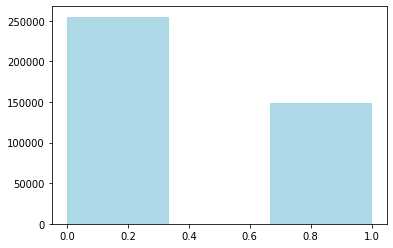

In [7]:
q1 = list(data['question1'].astype(str))
q2 = list(data['question2'].astype(str))
target = np.array(data['is_duplicate'])
plt.hist(target, color = 'lightblue', bins = 3)
plt.show()

In [8]:
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(q1+q2)
word_index = tokenizer.word_index
embedding_dim = 100
vocab = len(word_index)

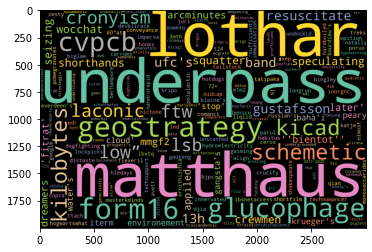

In [ ]:
wordcloud = WordCloud(width = 3000, height = 2000,
                      random_state=1, background_color='black', colormap='Set2', collocations=False).generate_from_frequencies(word_index)
plt.imshow(wordcloud)                      

In [9]:
def padding(texts):
  sequences = tokenizer.texts_to_sequences(texts)
  padded = pad_sequences(sequences,maxlen=30,padding='pre')
  return padded
padded1 = padding(q1)
padded2 = padding(q2)
padded = np.stack((padded1, padded2),axis=1)
x_train , x_test, y_train, y_test = train_test_split(padded, target, test_size=0.2,random_state=10)
q1_train = x_train[:,0]
q2_train = x_train[:,1]
q1_test = x_test[:,0]
q2_test = x_test[:,1]

In [33]:
x = Input(shape=(30,))
y = Input(shape=(30,))
emb1 = Embedding(vocab+1, embedding_dim, mask_zero = True)(x)
emb1 = LSTM(embedding_dim)(emb1)
emb2 = Embedding(vocab+1, embedding_dim, mask_zero = True)(y)
emb2 = LSTM(embedding_dim)(emb2)
z = Attention(dropout=0.2)([emb1, emb2])
z = BatchNormalization()(z)
z = Dense(200,activation='relu')(z)
z = Dropout(0.2)(z)
z = BatchNormalization()(z)
z = Dense(200,activation='relu')(z)
z = Dropout(0.2)(z)
z = Dense(1,activation='sigmoid')(z)

In [34]:
model = Model(inputs = [x,y], outputs = z)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 30, 300)      28681200    input_7[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 30, 300)      28681200    input_8[0][0]                    
____________________________________________________________________________________________

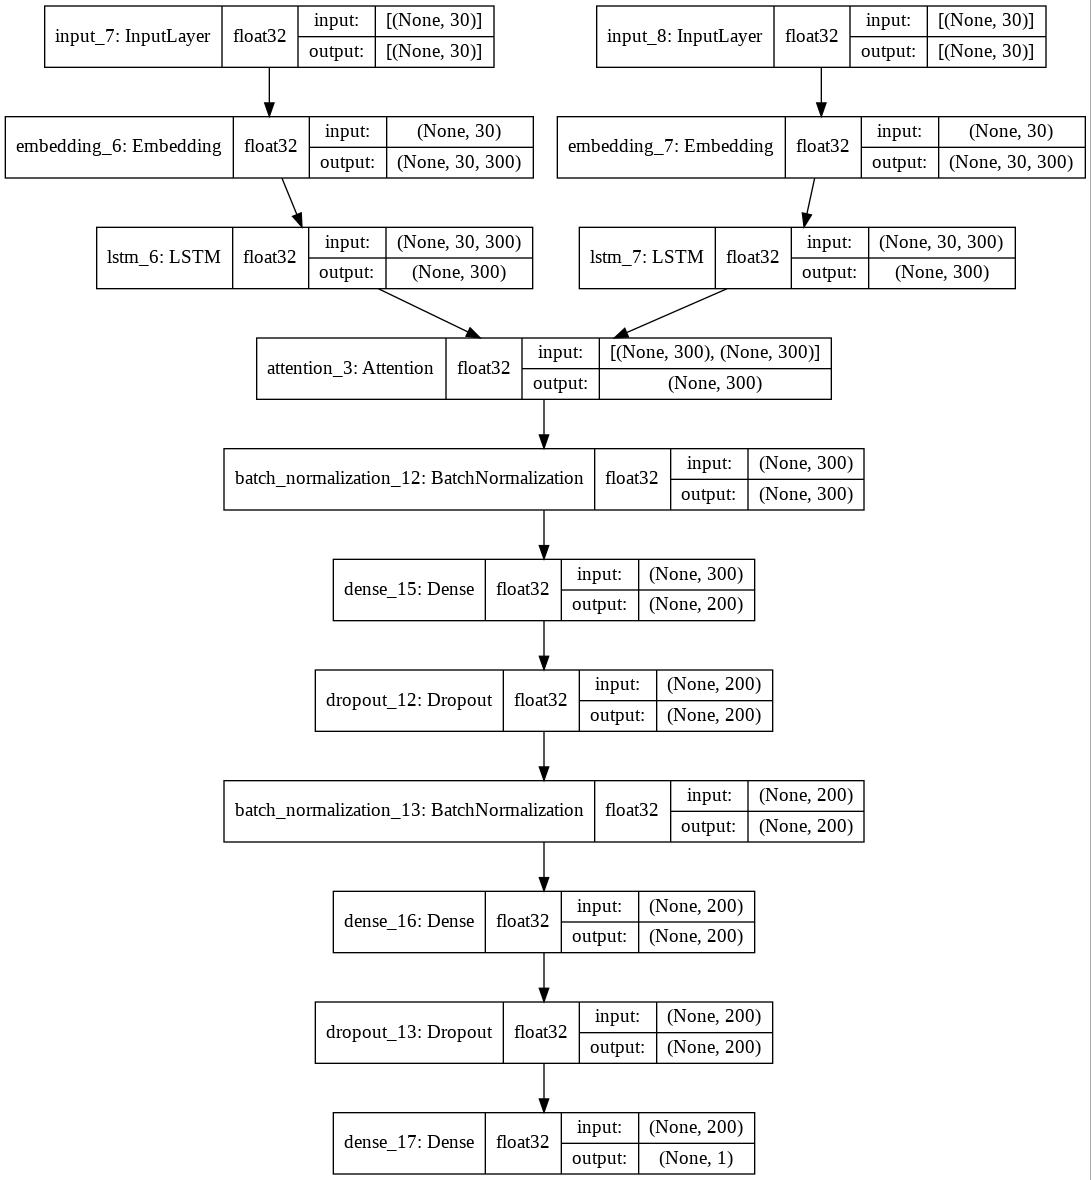

In [35]:
plot_model(model,to_file='model.jpeg',show_shapes=True,show_dtype=True)

In [36]:
cp_callback = ModelCheckpoint('model.save', monitor='loss', mode='min', save_best_only=True)
model.compile(optimizer = Adam(learning_rate=0.00099),loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x=[q1_train,q2_train],y=(y_train).reshape(y_train.shape[0], 1),epochs=10,
                    batch_size = 1024, verbose=1,validation_split = 0.1, callbacks=[cp_callback])

Epoch 1/10
285/285 [==============================] - 132s 430ms/step - loss: 0.5512 - acc: 0.7191 - val_loss: 0.6204 - val_acc: 0.6757


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 2/10
285/285 [==============================] - 119s 419ms/step - loss: 0.4773 - acc: 0.7701 - val_loss: 0.5333 - val_acc: 0.7532


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 3/10
285/285 [==============================] - 119s 417ms/step - loss: 0.4258 - acc: 0.7948 - val_loss: 0.5112 - val_acc: 0.7542


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 4/10
285/285 [==============================] - 118s 415ms/step - loss: 0.3837 - acc: 0.8129 - val_loss: 0.5715 - val_acc: 0.7553


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 5/10
285/285 [==============================] - 119s 416ms/step - loss: 0.3492 - acc: 0.8279 - val_loss: 0.5949 - val_acc: 0.7541


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 6/10
285/285 [==============================] - 118s 414ms/step - loss: 0.3201 - acc: 0.8424 - val_loss: 0.6290 - val_acc: 0.7491


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 7/10
285/285 [==============================] - 118s 414ms/step - loss: 0.2958 - acc: 0.8538 - val_loss: 0.6908 - val_acc: 0.7442


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 8/10
285/285 [==============================] - 118s 414ms/step - loss: 0.2720 - acc: 0.8658 - val_loss: 0.7532 - val_acc: 0.7499


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 9/10
285/285 [==============================] - 118s 413ms/step - loss: 0.2531 - acc: 0.8760 - val_loss: 0.7881 - val_acc: 0.7522


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


Epoch 10/10
285/285 [==============================] - 118s 413ms/step - loss: 0.2367 - acc: 0.8842 - val_loss: 0.8781 - val_acc: 0.7514


INFO:tensorflow:Assets written to: model.save/assets


INFO:tensorflow:Assets written to: model.save/assets


In [100]:
model.evaluate([q1_test, q2_test], y_test)

2528/2528 [==============================] - 70s 27ms/step - loss: 0.9128 - acc: 0.7447


[0.9128081202507019, 0.74470454454422]

In [106]:
shutil.make_archive('/content/drive/MyDrive/nlp','zip','/content/model.save')

'/content/drive/MyDrive/nlp.zip'

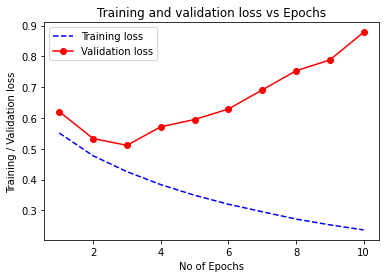

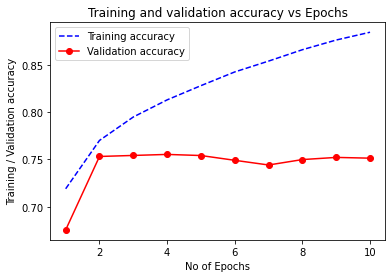

In [112]:
#Plotting
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, 11)

plt.plot(epochs, loss, '--', color = 'blue',label = "Training loss")
plt.plot(epochs, val_loss, '-o', color='red', label = "Validation loss")
plt.xlabel("No of Epochs")
plt.ylabel("Training / Validation loss")
plt.title("Training and validation loss vs Epochs")
plt.legend()
plt.show()

plt.plot(epochs, acc, '--', color = 'blue', label = "Training accuracy")
plt.plot(epochs, val_acc, '-o', color='red', label = "Validation accuracy")
plt.xlabel("No of Epochs")
plt.ylabel("Training / Validation accuracy")
plt.title("Training and validation accuracy vs Epochs")
plt.legend()
plt.show()

In [103]:
model = load_model('model.save')
def predict(input1, input2):
  i1 = padding(input1)
  i2 = padding(input2)
  prediction = model.predict([i1, i2])
  if prediction.max() > 0.5:
    print("Both the questions are similar")
  else:
    print("They are not similar questions")

In [105]:
i = int(input("Enter number of inputs to take: "))
while i > 0:
  p1 = input("Enter Question 1: ")
  p2 = input("Enter Question 2: ")  
  print("-------- The model prediction is --------")
  predict([p1], [p2])
  print("\n")
  i = i-1

Enter number of inputs to take: 2
Enter Question 1: What is Your Age?
Enter Question 2: How Old Are You?
-------- The model prediction is --------
Both the questions are similar


Enter Question 1: How long does the delivery take?
Enter Question 2: What is the shipping time?
-------- The model prediction is --------
Both the questions are similar


